In [1]:
# Import modules
import datetime
import spiceypy
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

# Load the SPICE kernels via a meta file
spiceypy.furnsh('kernel_meta.txt')

# Create an initial date-time object that is converted to a string
datetime_utc = datetime.datetime.now().strftime('%Y-%m-%dT%H:%M:%S')

# Convert to Ephemeris Time (ET) using the SPICE function utc2et
datetime_et = spiceypy.utc2et(datetime_utc)

In [2]:
# We want to compute the coordinates for different Solar System bodies as seen
# from our planet. First, a pandas dataframe is set that is used to append the
# computed data
solsys_df = pd.DataFrame()

# Add the ET and the corresponding UTC date-time string
solsys_df.loc[:, 'ET'] = [datetime_et]
solsys_df.loc[:, 'UTC'] = [datetime_utc]

# Set a dictionary that lists some body names and the corresponding NAIF ID
# code. Mars has the ID 499, however the loaded kernels do not contain the
# positional information. We use the Mars barycentre instead
SOLSYS_DICT = {'SUN': 10, 'VENUS': 299, 'MOON': 301, 'MARS': 4}

# Each body shall have an individual color; set a list with some colors
BODY_COLOR_ARRAY = ['y', 'tab:orange', 'tab:gray', 'tab:red']

In [3]:
# Now we want the coordinates in equatorial J2000. For this purpose we
# iterate through all celestial bodies
for body_name in SOLSYS_DICT:

    # First, compute the directional vector of the body as seen from Earth in
    # J2000
    solsys_df.loc[:, f'dir_{body_name}_wrt_earth_equ'] = solsys_df['ET'] \
        .apply(lambda x: spiceypy.spkezp(targ=SOLSYS_DICT[body_name], \
                                         et=x, \
                                         ref='J2000', \
                                         abcorr='LT+S', \
                                         obs=399)[0])

    # Compute the longitude and latitude values in equatorial J2000
    # coordinates
    solsys_df.loc[:, f'{body_name}_long_rad_equ'] = solsys_df[f'dir_{body_name}_wrt_earth_equ'] \
                                                        .apply(lambda x: spiceypy.recrad(x)[1])
    solsys_df.loc[:, f'{body_name}_lat_rad_equ'] = solsys_df[f'dir_{body_name}_wrt_earth_equ'] \
                                                        .apply(lambda x: spiceypy.recrad(x)[2])

    # Apply the same logic as shown before to compute the longitudes for the
    # matplotlib figure
    solsys_df.loc[:, f'{body_name}_long_rad4plot_equ'] = \
        solsys_df[f'{body_name}_long_rad_equ'] \
            .apply(lambda x: -1*((x % np.pi) - np.pi) if x > np.pi \
                   else -1*x)

In [4]:
# Before we plot the data, let's add the Ecliptic plane for the visualisation.
# In ECLIPJ2000 the Ecliptic plane is the equator line (see corresponding
# figure. The latitude is 0 degrees.

# First, we create a separate dataframe for the ecliptic plane
eclip_plane_df = pd.DataFrame()

# Add the ecliptic longitude and latitude values for the plane. Note: here,
# we need to use pi/2 (90 degrees) as the latitude, since we will apply a
# SPICE function that expects spherical coordinates
eclip_plane_df.loc[:, 'ECLIPJ2000_long_rad'] = np.linspace(0, 2*np.pi, 100)
eclip_plane_df.loc[:, 'ECLIPJ2000_lat_rad'] = np.pi / 2.0

# Compute the directional vectors of the ecliptic plane for the different
# longitude values (the latitude is constant). Apply the SPICE function sphrec
# to transform the spherical coordinates to vectors. r=1 is the distance,
# here in our case: normalised distance
eclip_plane_df.loc[:, 'ECLIPJ2000_direction'] = \
    eclip_plane_df \
        .apply(lambda x: spiceypy.sphrec(r=1, \
                                         colat=x['ECLIPJ2000_lat_rad'], \
                                         lon=x['ECLIPJ2000_long_rad']), \
               axis=1)

In [5]:
# Compute a transformation matrix between ECLIPJ2000 and J2000 for a fixed
# date-time. Since both coordinate system are inertial (not changing in time)
# the resulting matrix is the same for different ETs
ecl2equ_mat = spiceypy.pxform(fromstr='ECLIPJ2000', \
                              tostr='J2000', \
                              et=datetime_et)

# Compute the direction vectors of the Ecliptic plane in J2000 using the
# transformation matrix
eclip_plane_df.loc[:, 'j2000_direction'] = \
    eclip_plane_df['ECLIPJ2000_direction'].apply(lambda x: ecl2equ_mat.dot(x))

# Compute now the longitude (and matplotlib compatible version) and the
# latitude values using the SPICE function recrad
eclip_plane_df.loc[:, 'j2000_long_rad'] = \
    eclip_plane_df['j2000_direction'].apply(lambda x: spiceypy.recrad(x)[1])

eclip_plane_df.loc[:, 'j2000_long_rad4plot'] = \
    eclip_plane_df['j2000_long_rad'] \
        .apply(lambda x: -1*((x % np.pi) - np.pi) if x > np.pi \
               else -1*x)

eclip_plane_df.loc[:, 'j2000_lat_rad'] = \
    eclip_plane_df['j2000_direction'].apply(lambda x: spiceypy.recrad(x)[2])

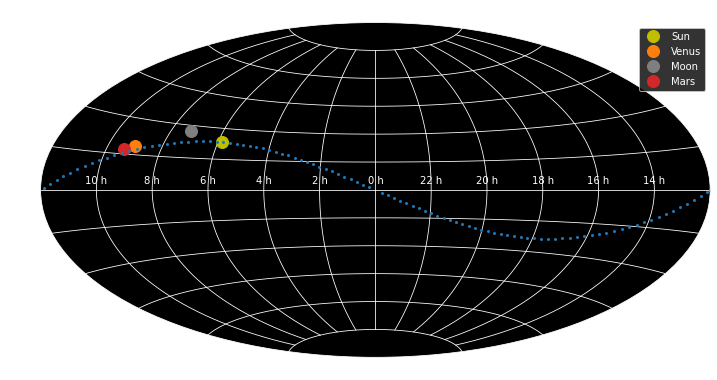

In [6]:
# We plot now the data in equatorial J2000. Again with a dark background and
# the same properties as before
plt.style.use('dark_background')
plt.figure(figsize=(12, 8))
plt.subplot(projection="aitoff")
plt.title(f'{datetime_utc} UTC', fontsize=10)

# Iterate through the celestial bodies and plot them
for body_name, body_color in zip(SOLSYS_DICT, BODY_COLOR_ARRAY):

    plt.plot(solsys_df[f'{body_name}_long_rad4plot_equ'], \
             solsys_df[f'{body_name}_lat_rad_equ'], \
             color=body_color, marker='o', linestyle='None', markersize=12, \
             label=body_name.capitalize())

# Plot the Ecliptic plane as a blue dotted line
plt.plot(eclip_plane_df['j2000_long_rad4plot'], \
         eclip_plane_df['j2000_lat_rad'], color='tab:blue', linestyle='None', \
         marker='o', markersize=2)

# Convert the longitude values finally in right ascension hours
plt.xticks(ticks=np.radians(np.arange(-150, 180, 30)),
           labels=['10 h', '8 h', '6 h', '4 h', '2 h', '0 h', \
                   '22 h', '20 h', '18 h', '16 h', '14 h'])

# Plot the labels
plt.xlabel('Right ascension in hours')
plt.ylabel('Declination in deg.')

# Create a legend and grid
plt.legend()
plt.grid(True)

# Save the figure
plt.savefig('j2000_sky_map.png', dpi=300)